First, we need to import the files with our individual methods for extracting object tracking data. Both files should contain a methods that return object coordinates from different times in the video, that have been extracted using the two different methods we investigated.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import model as mdl
import os

from pylab import rcParams


rcParams['figure.figsize'] = 10, 30

Looking at some sample bounding box inputs to model: ground truth annotations from dataset for training data and predicted bounding boxes using frame differencing method for the testing set.

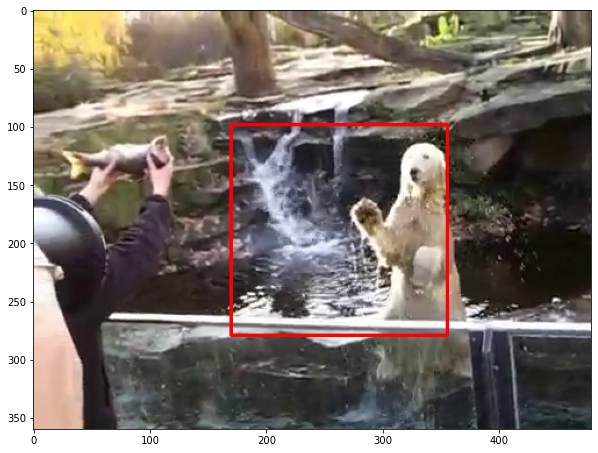

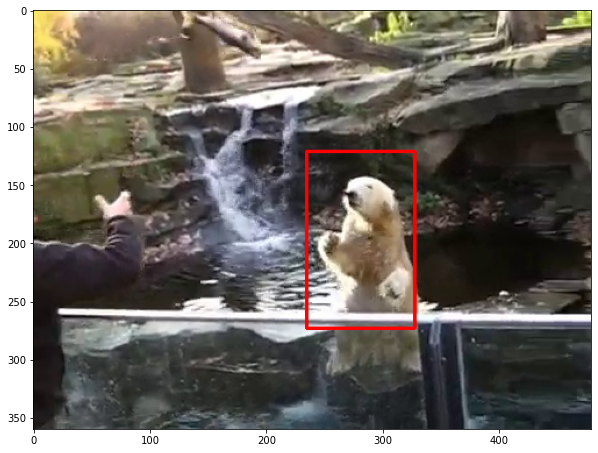

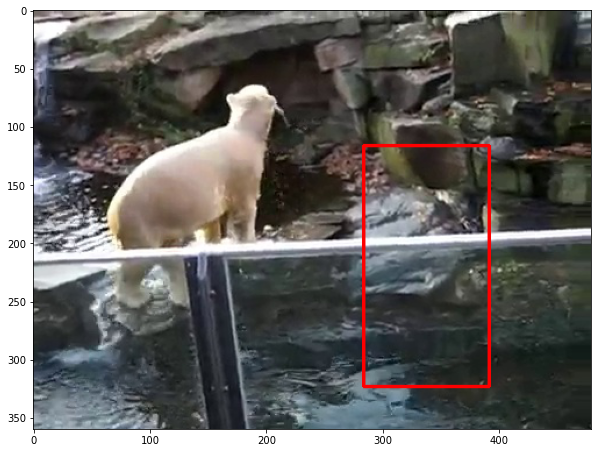

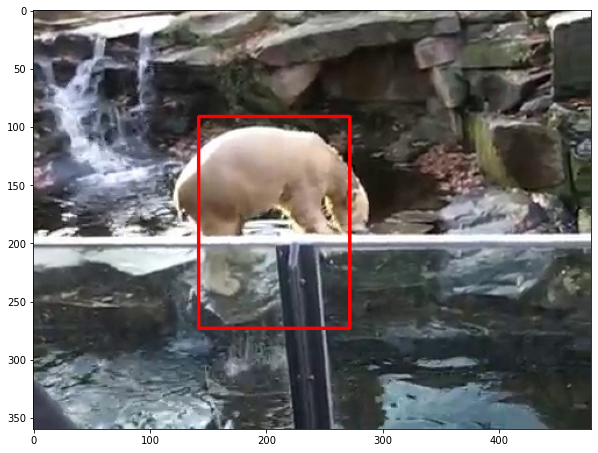

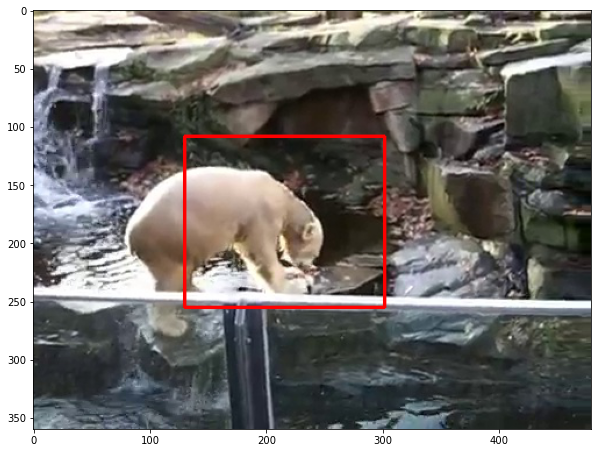

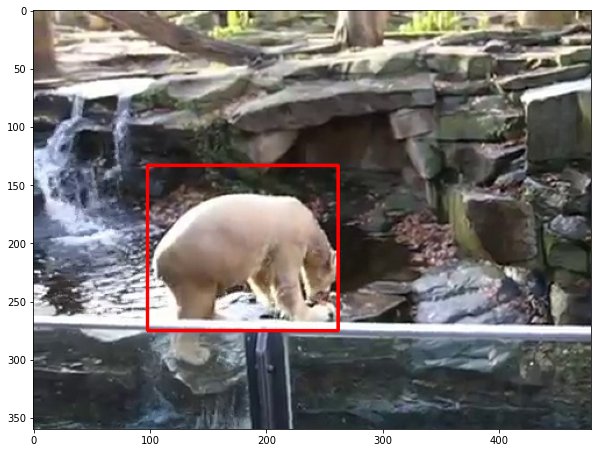

In [2]:
frames, boxes = mdl.load_video_data("baby", 'A_weMKVolQM_3')

num_frames = 6
step = 60


for i in range(5, 5+ step * num_frames, step):
    box = boxes[i]
    frame = cv2.rectangle(frames[i], (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
    plt.figure()
    plt.imshow(frame)

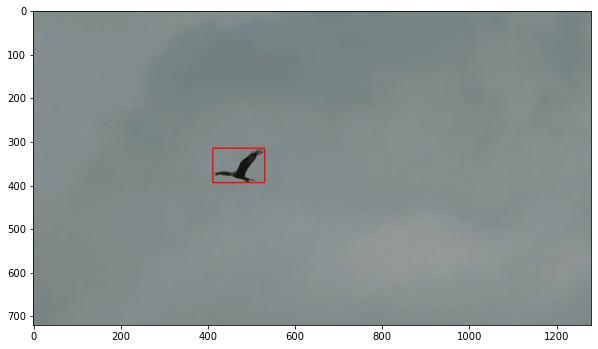

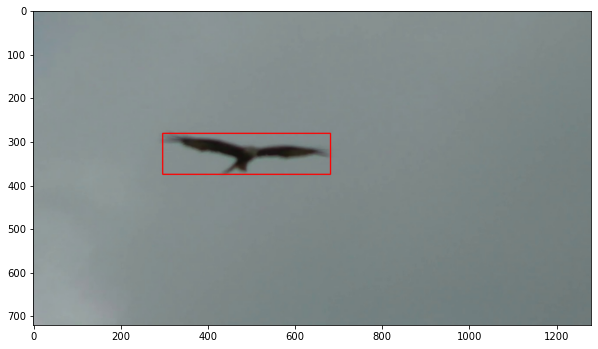

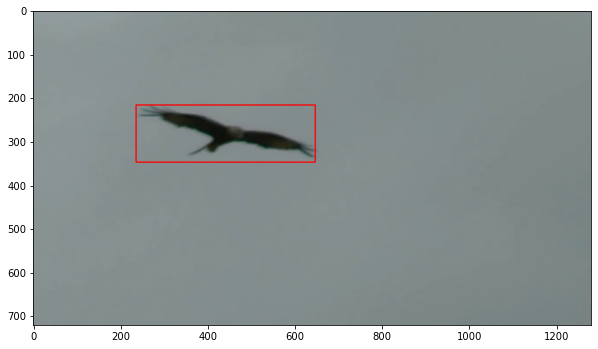

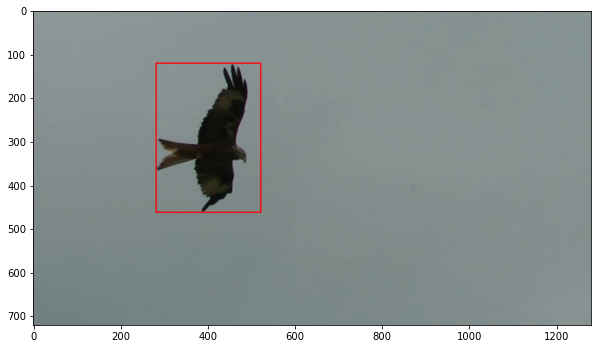

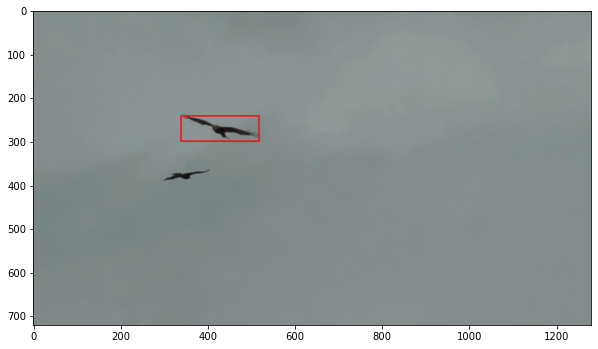

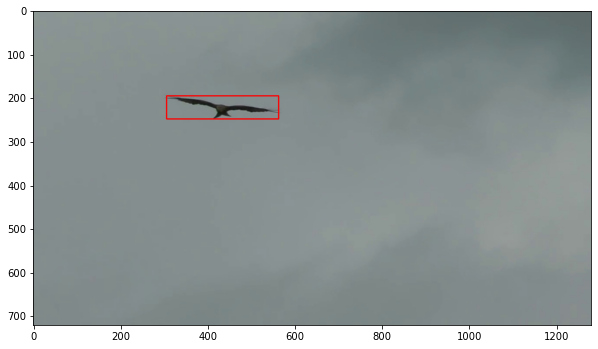

In [3]:
frames, boxes = mdl.load_video_data("baby_test", '_tcyjMmMSRk_0')

num_frames = 6
step = 60

for i in range(0, step * num_frames, step):
    box = boxes[i]
    frame = cv2.rectangle(frames[i], (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
    plt.figure()
    plt.imshow(frame)

Looking more in depth at the frame differencing method, we can look at some of the contours generated and the bounding boxes that result from them.

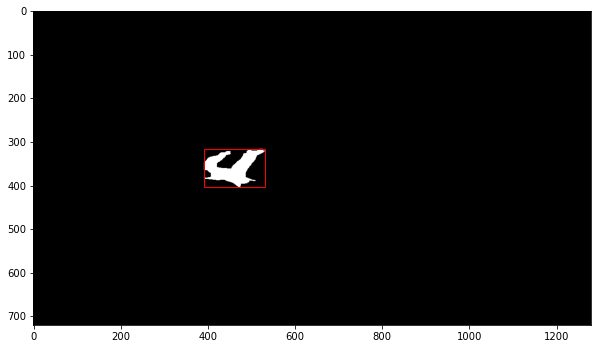

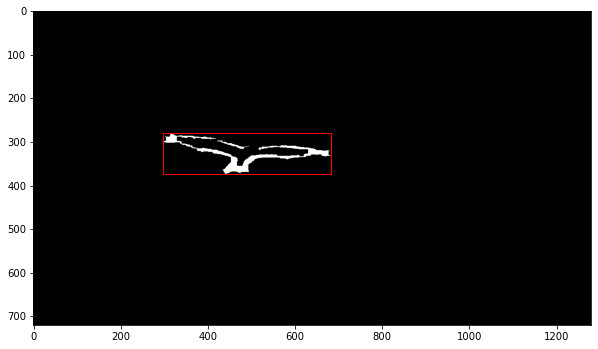

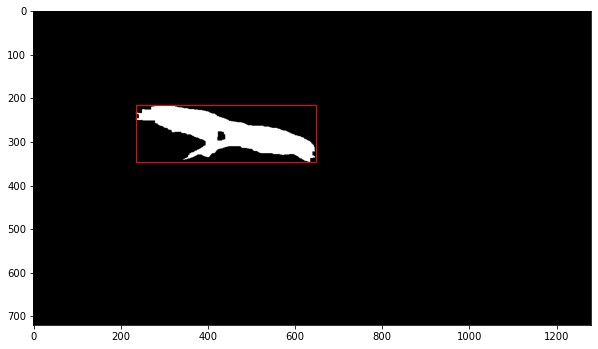

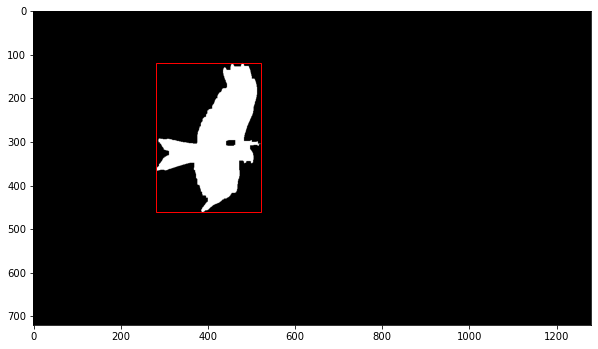

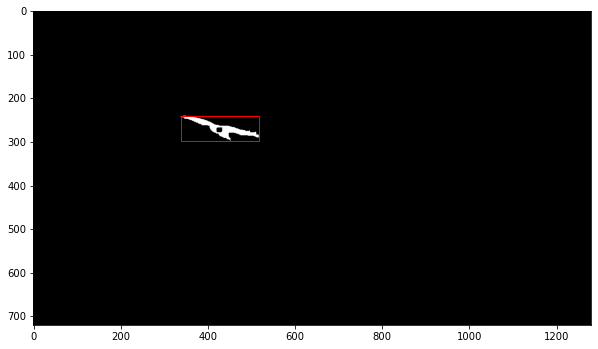

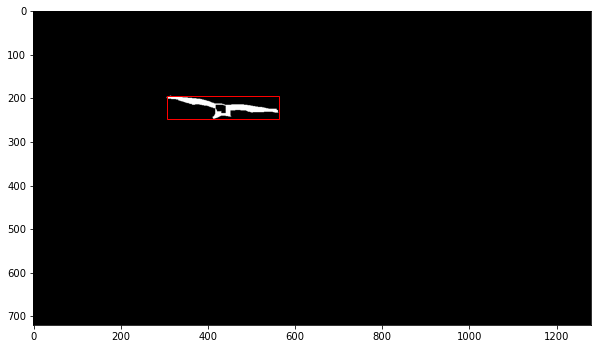

In [4]:
# loads in video data while printing the contour and bounding box output for every 60th frame

frames, boxes = mdl.load_video_data("baby_test", '_tcyjMmMSRk_0', True)
# '_O85LwqCB7k_0'

Creating and training the model on a subset of the TrackingNet Dataset, loading in pretrained MS COCO weights for improved accuracy. This outputs the inference model, and we can take a look at some of the predicted bounding box outputs overlaid on the actual image for the testing and training datasets. I trained for 3 epoch with 131 training steps in each. 



In [5]:
model, data, test_set, cfg = mdl.main()

Train: 16925
Test: 3372
Instructions for updating:
Use fn_output_signature instead


For the inference model, we load in the weights from the configuration file generated from training the Mask R-CNN model before making the predictions shown in the plots that follow.

In [33]:
epoch = 3

# load model weights
for folder in os.listdir():
    if "obj_cfg" in folder: 
        path = folder
model_path = path + '/mask_rcnn_obj_cfg_000' + str(epoch) + '.h5'
model.load_weights(model_path, by_name=True)




rcParams['figure.figsize'] = 10, 20

[  0 479   2 480]
[  0 479   2 480]
[  0 479   2 480]
[  0 479   2 480]
[  0 479   2 480]


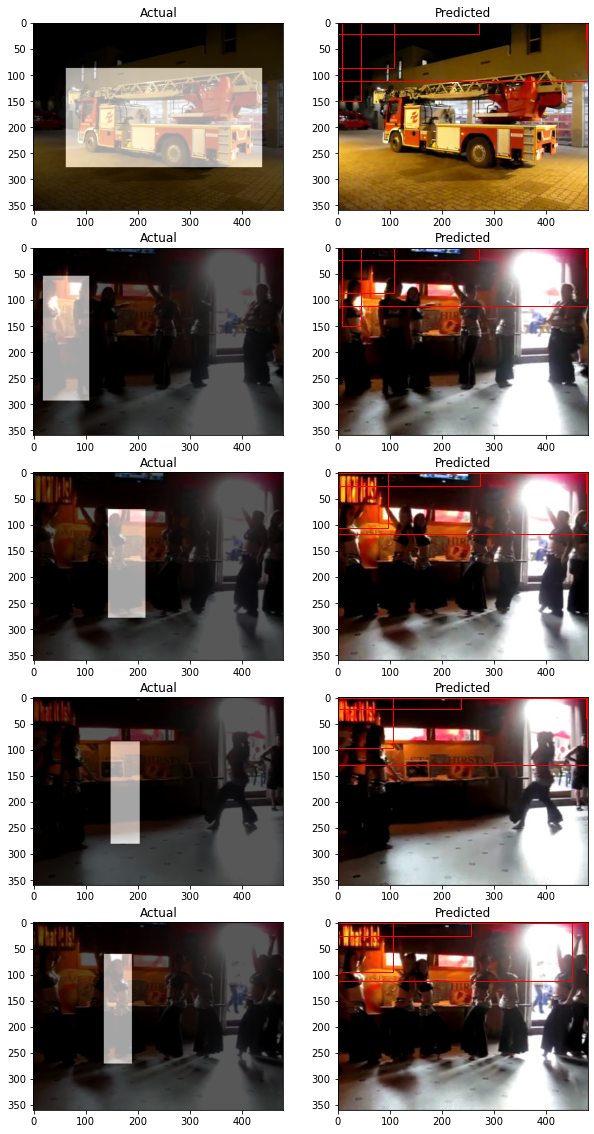

In [34]:
# plot predictions for train dataset
mdl.plot_actual_vs_predicted(data, model, cfg)


[   0 1279    1 1280]
[   0 1279    1 1280]
[   0 1279    1 1280]
[   0 1279    1 1280]
[   0 1279    1 1280]


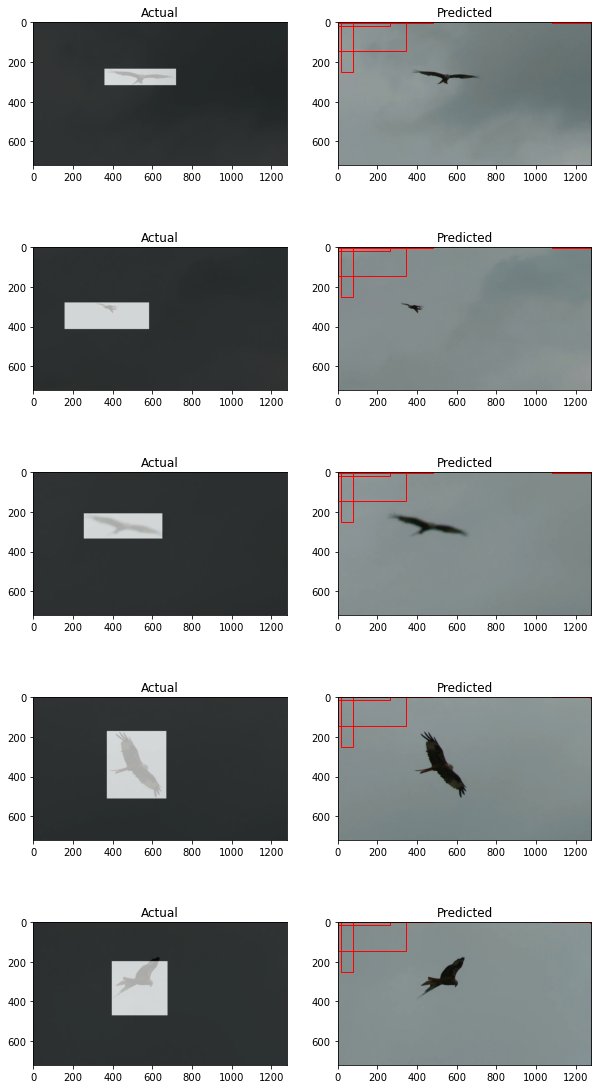

In [36]:
# plot predictions for test dataset
mdl.plot_actual_vs_predicted(test_set, model, cfg)

In order to improve our object tracking, we can pass our measurements into a Kalman filter using a constant velocity process model. The constant velocity process model may not be accurate for the datasets, but using the extracted object tracking data in the update step should result in an accurate representation.

In [9]:
import numpy as np
from numpy.linalg import inv,cholesky
import random


def prediction_step(X, C, A, Q):
    """ Inputs: last time step position mean vector X and covariance matrix C
        transition matrix A, and process noise coviariance matrix Q
        Outputs: predicted mean vector and covariance matrix 
    """
    
    new_X = np.dot(A,X)
    new_C = np.dot(A, np.dot(C, A.T)) + Q
    
    return (new_X,new_C)

def update_step(X, C, Z, H, R):
    """ Inputs: predicted position mean vector X, predicted covariance matrix C,
        measurement vector Z, measurement matrix H, and measurement covariance matrix R
        Outputs: End of time step update mean and covariance
    """
    Y = Z - np.dot(H,X)                        # measurement residual
    S = np.dot(H, np.dot(C, H.T)) + R          # innovation covariance
    K = np.dot(C, np.dot(H.T, inv(S)))         # optimal kalman gain
    new_X = X + np.dot(K,Y)
    new_C = C - np.dot(K, np.dot(S, K.T))
    
    
    
    return (new_X,new_C)



Here is a simple object tracking Kalman filter example, where the measurements are generated from the true position vector to represent measurement noise in a true system. This example shows one object moving in a parabolic trajectory, using a constant velocity model as the process model, and the generated measurements in the update step.

In [10]:
# This cell intitializes matrices and measurements we can use for an example of the filter at work


# random velocity vector
v_x = random.randrange(0,5)                        # x velocity
v_y = random.randrange(0,5)                        # y velocity
v_z = random.randrange(0,5)                        # z velocity
u = np.array([v_x, v_y, v_z]).T                    # input vector - velocity vector 

N = 50                                  # number of time steps
dt = .1                                  # size of time steps
t = dt * np.array(range(0,N)).T           # time vector 

# how long it runs and velocity determine movement boundaries
total_time = N*dt              


# creating positive semi-definite matrices for covariances 
Q = np.random.rand(3,3)
R = np.random.rand(3,3)
C = np.random.rand(3,3)
Q = np.dot(Q, Q.transpose())
R = np.dot(R, R.transpose())
C = np.dot(C, C.transpose())

    
F = np.eye(3,3)
G = dt*np.eye(3,3)
H = np.eye(3,3)  


# true initial state
x0 = random.randrange(0,10)
y0 = random.randrange(0,10)
z0 = random.randrange(0,10)                  

                  
x_dim = x0 + total_time * v_x
y_dim = y0 + total_time * v_y
z_dim = z0+ total_time * v_z   
                  
                  
# setting up the state vector and initial measurement
ht = np.zeros((3, N))
ht[:, 0] = np.array([x0, y0, z0]).T


# filling the rest of the vector using the true values
for k in range(1,N):
    # previous position plus velocity times time
    ht[:,k] = np.dot(F, ht[:,k-1]) + np.dot(G,u)


Z = np.zeros((N,3))

for i in range(0,N):
    cholR = cholesky(R)
    v = np.dot(cholR, np.random.rand(3))
    Z[i,:] = np.dot(H, ht[:,i]) + v

    


In [11]:
# Using the generated measurements, we can compare predicted position to true position


# initial state
predictions = np.zeros((N,3))
predictions[0,:] = np.array([2,2,2])

for i in range(1,len(Z)):
    z = Z[i]
    predictions[i,:], C = prediction_step(predictions[i-1,:],C,F,Q)
    predictions[i,:], C = update_step(predictions[i,:], C, z, H, R)
    


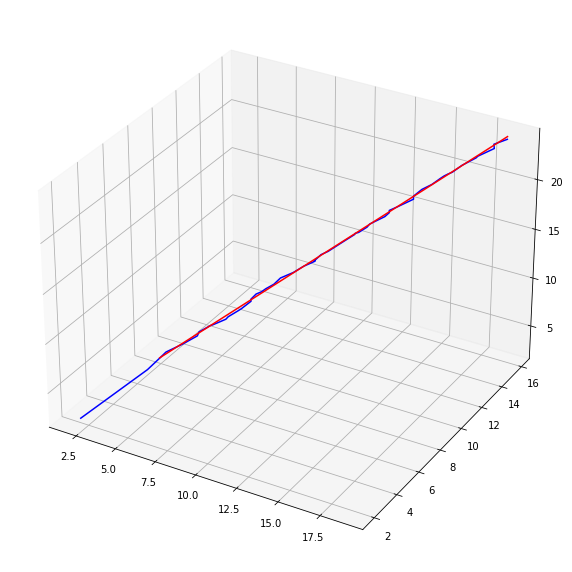

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

true_pos = ht.T

# plot 3d for x,y,z position
fig = plt.figure()
ax = plt.axes(projection='3d')

xline = predictions[:,0]
yline = predictions[:,1]
zline = predictions[:,2]

ax.plot3D(xline, yline, zline, 'blue')

xline1 = true_pos[:,0]
yline1 = true_pos[:,1]
zline1 = true_pos[:,2]

ax.plot3D(xline1, yline1, zline1, 'red')

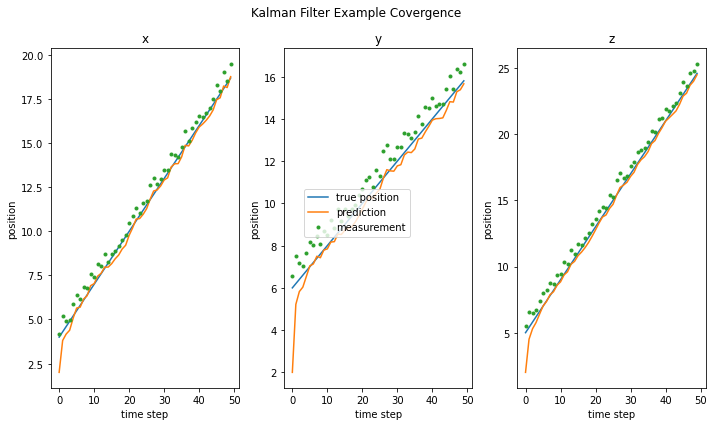

In [13]:
# plots for individual coordinate predictions

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
fig.suptitle('Kalman Filter Example Covergence')

ax1.set_xlabel('time step')
ax1.set_ylabel('position')
ax2.set_xlabel('time step')
ax2.set_ylabel('position')
ax3.set_xlabel('time step')
ax3.set_ylabel('position')

ax1.plot(true_pos[:,0])
ax1.plot(predictions[:,0])
ax1.plot(Z[:,0], '.')
ax1.set_title("x")

ax2.plot(true_pos[:,1])
ax2.plot(predictions[:,1])
ax2.plot(Z[:,1], '.')
ax2.set_title("y")

ax3.plot(true_pos[:,2], label='true position')
ax3.plot(predictions[:,2], label='prediction')
ax3.plot(Z[:,2], '.', label='measurement')
ax3.set_title('z')


lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'center')


plt.tight_layout()



Now we can slightly modify the kalman filter structure to take into account the structure of the measurements. By using our bounding box predictions in the update step of the Kalman filter along with a constant velocity process model we hope to more accurately and smoothly predict object motion. To simplify this Kalman filter implementation, we are going to ignore the z dimension (depth) of the object, and use the x,y coordinates of the center of the generated box.

In [14]:
# input list of images from a video folder:

from PIL import Image


dir = 'baby_test'
folder = '_tcyjMmMSRk_0'

boxes = []
for (i,image) in enumerate(os.listdir(dir+'/zips/'+folder)):

    if i % 4 == 0:

        im = Image.open(dir+'/zips/'+folder+"/"+image)
        im = np.array(im)
        im = mdl.mold_image(im,cfg) 
        sample = np.expand_dims(im, 0)

        x = model.detect(sample, verbose=0)[0]
        scores =  list(x['scores'])
        box_list = x['rois']

        max_value = max(scores)
        max_index = scores.index(max_value)
        
        boxes += [(i, box_list[max_index])]


print(boxes[:5])



[(0, array([   0, 1279,    1, 1280])), (4, array([   0, 1279,    1, 1280])), (8, array([   0, 1279,    1, 1280])), (12, array([   0, 1279,    1, 1280])), (16, array([   0, 1279,    1, 1280]))]


In [15]:
frames, framediffBoxes = mdl.load_video_data("baby_test", '_tcyjMmMSRk_0')

fBoxes = []
for i in range(len(frames)):
    if i % 4 == 0:
        fBoxes += [framediffBoxes[i]]


print(fBoxes[:5])


[[412, 314, 531, 393], [352, 321, 456, 388], [352, 321, 456, 388], [332, 318, 431, 376], [408, 283, 471, 308]]


In [16]:
# generate measurements array with x and y for bounding box center 

Z = np.zeros((len(boxes),2))
ZF = np.zeros((len(boxes),2))
for i in range(len(boxes)):

    box = boxes[i]
    box1 = box[1]
    box2 = fBoxes[i]

    x = (box1[0] + box1[2])/2
    y = (box1[1] + box1[3])/2

    x1 = (box2[0] + box2[2])/2
    y1 = (box2[1] + box2[3])/2

    j = int(box[0]/4)

    Z[j,0] = x
    Z[j,1] = y

    
    ZF[j,0] = x1
    ZF[j,1] = y1


print(Z[:5])
print(ZF[:5])

[[5.0000e-01 1.2795e+03]
 [5.0000e-01 1.2795e+03]
 [5.0000e-01 1.2795e+03]
 [5.0000e-01 1.2795e+03]
 [5.0000e-01 1.2795e+03]]
[[471.5 353.5]
 [404.  354.5]
 [404.  354.5]
 [381.5 347. ]
 [439.5 295.5]]


In [17]:
# creating positive semi-definite matrices for covariances 
Q = np.random.rand(2,2)
R = np.random.rand(2,2)
C = np.random.rand(2,2)
Q = np.dot(Q, Q.transpose())
R = np.dot(R, R.transpose())
C = np.dot(C, C.transpose())

    
F = np.eye(2,2)
G = dt*np.eye(2,2)
H = np.eye(2,2)  

In [18]:
# Using the generated measurements, we can compare predicted position to true position


# initial state
vidPredictions = np.zeros((len(Z),2))
vidPredictionsF = np.zeros((len(Z),2))

vidPredictions[0,0] = np.array([framediffBoxes[0][0], framediffBoxes[0][1]])[0]
vidPredictions[0,1] = np.array([framediffBoxes[0][0], framediffBoxes[0][1]])[1]
vidPredictionsF[0,0] = np.array([framediffBoxes[0][0], framediffBoxes[0][1]])[0]
vidPredictionsF[0,1] = np.array([framediffBoxes[0][0], framediffBoxes[0][1]])[1]

C1=C

for i in range(1,len(Z)):
    z = Z[i]

    vidPredictions[i,:], C = prediction_step(vidPredictions[i-1,:],C,F,Q)
    vidPredictions[i,:], C = update_step(vidPredictions[i,:], C, z, H, R)

    zf = ZF[i]
    vidPredictionsF[i,:], C1 = prediction_step(vidPredictionsF[i-1,:],C1,F,Q)
    vidPredictionsF[i,:], C1 = update_step(vidPredictionsF[i,:], C1, zf, H, R)

print(vidPredictions[:5, :])
print(vidPredictionsF[:5, :])
    

[[ 412.          314.        ]
 [  88.55439416 1221.35344825]
 [  84.7769014  1303.40049461]
 [  47.95387134 1300.83415423]
 [  23.11697884 1291.00116547]]
[[412.         314.        ]
 [405.38880137 350.98756669]
 [406.55017023 354.99067584]
 [395.1080808  353.2656792 ]
 [373.51011035 277.4620086 ]]


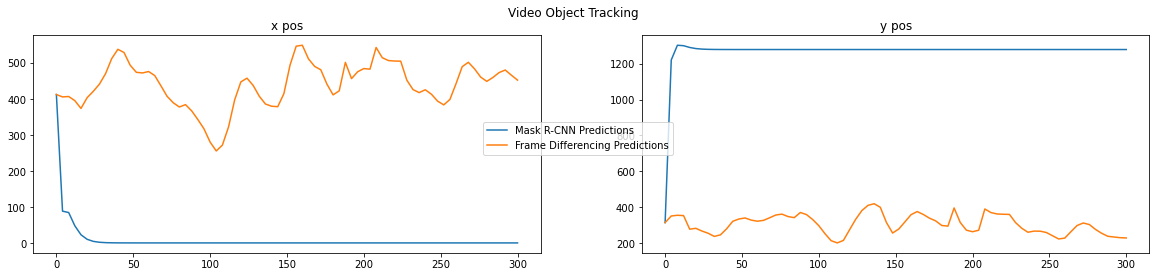

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Video Object Tracking')

length = len(os.listdir(dir+'/zips/'+folder))

ax1.plot(range(0,length,4),vidPredictions[:,0])
ax1.plot(range(0,length,4),vidPredictionsF[:,0])
ax1.set_title("x pos")


ax2.plot(range(0,length,4),vidPredictions[:,1], label="Mask R-CNN Predictions")
ax2.plot(range(0,length,4),vidPredictionsF[:,1], label="Frame Differencing Predictions")
ax2.set_title("y pos")


lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'center')


rcParams['figure.figsize'] = 20, 4

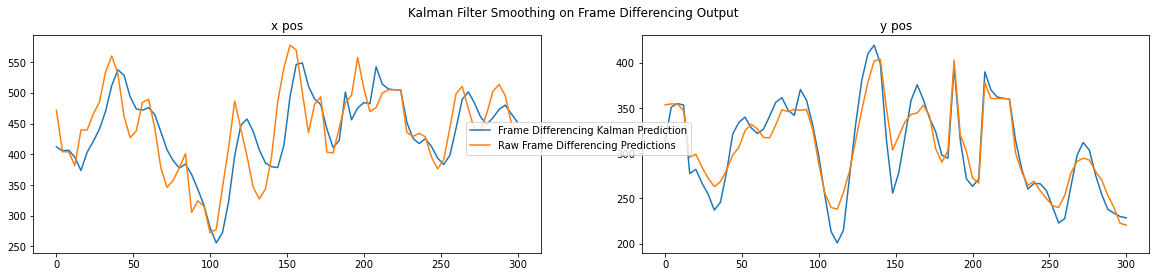

In [52]:

fig1, (ax1, ax2) = plt.subplots(1,2)
fig1.suptitle('Kalman Filter Smoothing on Frame Differencing Output')

length = len(os.listdir(dir+'/zips/'+'_tcyjMmMSRk_0'))

ax1.plot(range(0,length,4),vidPredictionsF[:,0])
ax1.plot(range(0,length,4),ZF[:,0])
ax1.set_title("x pos")


ax2.plot(range(0,length,4),vidPredictionsF[:,1], label="Frame Differencing Kalman Prediction")
ax2.plot(range(0,length,4),ZF[:,1], label="Raw Frame Differencing Predictions")
ax2.set_title("y pos")


lines, labels = fig1.axes[-1].get_legend_handles_labels()
    
fig1.legend(lines, labels, loc = 'center')


rcParams['figure.figsize'] = 20, 4

